In [ ]:
import operator
from typing import TypedDict, Annotated, List, Dict, Any
import asyncio

# Assuming these imports are available in your environment
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END, START

# Import local services
from summarization import Summarizer, CostarPrompt # CostarPrompt is assumed to be importable
from evaluation_service import EvaluationAgent

# ====================================================
# 1. Define State
# ====================================================
class SummarizationState(TypedDict):
    source_text: str  # The full original article content
    initial_summary: str
    current_draft: str # The draft being evaluated/refined
    
    # Evaluation Data
    eval_score: float
    eval_feedback: str # Detailed feedback from the Judge (e.g., "Factual Fidelity Score: 0.6. Claim 'X' is unsupported.")
    is_passing: bool
    
    # Loop control
    retry_count: int

# ====================================================
# 2. Setup (Global Instances)
# ====================================================
# Initialize LLM workers (use the fine-tuned model for generation)
summarizer_instance = Summarizer() 

# Initialize the Judge (using 'summarization' task type)
_evaluator = EvaluationAgent(
    task_type="summarization", 
    threshold=0.85,
    model_name="gpt-5-mini" 
)

# ====================================================
# 3. Add Refinement Logic to Summarizer Class
# ====================================================
# This function is necessary for the refinement_node (Optimizer) to work
def refine_summary_logic(source_text: str, current_draft: str, improvements: str) -> str:
    """
    Refines the summary based on external evaluation feedback (improvements).
    
    This replaces the 'refine_translation' call in the original workflow.
    """
    # Use the CoSTAR framework to structure the refinement request
    refinement_costar = CostarPrompt(
        context="You are a meticulous Senior Editor, tasked with refining a corporate news summary based on critical feedback. Your primary goal is to fix factual errors and ensure the tone is highly professional.",
        objective=f"Rework the summary to strictly address the following feedback and constraints:\n\n### FEEDBACK ###\n{improvements}",
        audience="The final audience is a senior investment editor.",
        response=f"Output the final refined summary (3-4 sentences ONLY) that is factually flawless and maintains an impeccable executive tone. Base all facts ONLY on the source article provided below.\n\n### SOURCE ARTICLE ###\n{source_text}"
    )
    
    prompt_content = f"{str(refinement_costar)}\n\n### CURRENT DRAFT ###\n{current_draft}"

    messages = [
        summarizer_instance.system_message, # Use the defined SystemMessage
        HumanMessage(content=prompt_content)
    ]
    
    response = summarizer_instance.llm.invoke(messages)
    return response.content.strip()

# ====================================================
# 4. Define Graph Nodes (Adapted from Translation Workflow)
# ====================================================

def initial_summarization_node(state: SummarizationState) -> Dict[str, Any]:
    """Worker: Generate the initial 0-shot summary."""
    print(f"\n--- [Step 1] Initial Summarization ---")
    
    # Use the existing summarize function (Costar-driven)
    res = summarizer_instance.summarize(state["source_text"])
    
    return {
        "initial_summary": res, 
        "current_draft": res, 
        "eval_feedback": "",
        "retry_count": 0
    }

async def summarization_evaluation_node(state: SummarizationState) -> Dict[str, Any]:
    """Judge: DeepEval checks the draft against Source."""
    print(f"--- [Step 2] Evaluation (DeepEval) ---")
    
    # Use the ASYNC evaluator
    results = await _evaluator.a_evaluate(
        generated_text=state["current_draft"],
        source_context=state["source_text"],
        section_topic="Corporate News Summary"
    )
    
    # Aggregate feedback from failing metrics
    feedback_list = []
    for name, m in results["metrics"].items():
        if not m["passed"]:
            feedback_list.append(f"[{name}] Score: {m['score']:.2f}. Feedback: {m['feedback']}")
            
    return {
        "eval_score": results["average_score"],
        "is_passing": results["overall_pass"],
        "eval_feedback": " ".join(feedback_list)
    }

def summarization_refinement_node(state: SummarizationState) -> Dict[str, Any]:
    """Optimizer: Rewrite summary using Feedback."""
    current_retries = state["retry_count"]
    print(f"--- [Step 3] Refinement (Attempt {current_retries + 1}) ---")
    
    # Use the new refinement logic
    refined = refine_summary_logic(
        source_text=state["source_text"],
        current_draft=state["current_draft"],
        improvements=state["eval_feedback"]
    )
    
    return {
        "current_draft": refined, 
        "retry_count": current_retries + 1
    }


def summarization_check_quality(state: SummarizationState) -> str:
    """Decide: Loop back or Finish?"""
    if state["is_passing"]:
        return "pass"
    
    # Critical threshold for looping
    if state["retry_count"] >= 3:
        print("   🛑 Max retries reached. Returning best effort.")
        return "pass" 
        
    return "retry"

# ====================================================
# 5. Build Graph (Self-Correcting Summarizer Agent)
# ====================================================

def create_summarization_agent_graph() -> StateGraph:
    """
    Builds the LangGraph for the self-correcting summarization agent.
    
    """
    workflow = StateGraph(SummarizationState)
    
    # Nodes
    workflow.add_node("initial", initial_summarization_node)
    workflow.add_node("evaluate", summarization_evaluation_node) # Judge
    workflow.add_node("refiner", summarization_refinement_node) # Optimizer
    
    # Flow
    workflow.add_edge(START, "initial")
    workflow.add_edge("initial", "evaluate")
    
    # Conditional Loop: Judge -> Pass (END) or Fail (refiner)
    workflow.add_conditional_edges(
        "evaluate",
        summarization_check_quality,
        {
            "pass": END, 
            "retry": "refiner" # Loop back to refine
        }
    )
    
    # After refinement, re-evaluate
    workflow.add_edge("refiner", "evaluate")
    
    return workflow.compile()

2025-12-07 09:04:27,683 [INFO] Initialized EvaluationAgent for task: summarization


In [3]:
app = create_summarization_agent_graph()

initial_state = {
    "scraped_articles": [],
    "run_status": "Starting Ingestion",
    "eval_scores": [],
    "max_retries": 0,
    "current_retry": 0,
}


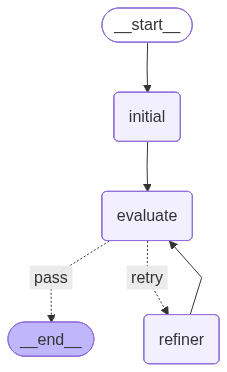

In [4]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Could not generate graph visualization. You might need 'grandalf' or similar.")

In [7]:
import pandas as pd
import json
import re

# Configuration
INPUT_FILE = 'data/Data/finetune_dataset_v2_07122025.xlsx' # Or your .xlsx file
OUTPUT_FILE = 'finetune_dataset_v2_07122025.jsonl'

# 1. Define the System & User Prompts (Must match your inference logic!)
SYSTEM_PROMPT = "You are a specialized financial summarization engine. Read the structured request and generate the summary strictly following the rules."

# This matches the "Modified Prompt" we discussed to allow strategic quotes
COSTAR_INSTRUCTION = """
CONTEXT: You are a corporate news analyst preparing brief updates for an investment report.
OBJECTIVE: Analyze the full corporate news article and generate a concise abstractive summary.
AUDIENCE: The target audience is a senior investment editor or portfolio manager who needs quick, factual insights.
RESPONSE GUIDELINES:
1. **Structure:** Exactly 3 to 5 sentences.
2. **Content:** Prioritize hard data (Revenue, Profit, Dates).
3. **Tone:** Professional financial journalism.
4. **Quote Policy:** - **PERMITTED:** You MAY use quotes for key strategic announcements (e.g., "Company searching for new CEO", "Targeting completion by 2026").
- **FORBIDDEN:** DO NOT use quotes for emotional/promotional language (e.g., "We are delighted," "We are proud").
5. **Formatting:** Use standard abbreviations (RM, %, bn, m).

### SOURCE ARTICLE ###
"""
def convert_to_jsonl():
    print(f"Reading from {INPUT_FILE}...")
    
    # Load Data
    if INPUT_FILE.endswith('.csv'):
        df = pd.read_csv(INPUT_FILE)
    else:
        df = pd.read_excel(INPUT_FILE)

    # Basic cleaning
    df = df.dropna(subset=['text', 'description'])
    
    # Conversion Loop
    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
        valid_count = 0
        
        for index, row in df.iterrows():
            # Extract content
            source_text = str(row['text']).strip()
            target_summary = str(row['description']).strip()
            
            # Skip empty rows
            if not source_text or not target_summary:
                continue

            # Construct the Training Example
            entry = {
                "messages": [
                    {
                        "role": "system", 
                        "content": SYSTEM_PROMPT
                    },
                    {
                        "role": "user", 
                        "content": f"{COSTAR_INSTRUCTION}\n{source_text}"
                    },
                    {
                        "role": "assistant", 
                        "content": target_summary
                    }
                ]
            }
            
            # Write to file (one JSON object per line)
            f.write(json.dumps(entry) + '\n')
            valid_count += 1

    print(f"✅ Successfully created {OUTPUT_FILE} with {valid_count} examples.")
    print("You can now upload this file to OpenAI for fine-tuning.")

In [10]:
convert_to_jsonl()

Reading from data/Data/finetune_dataset_v2_07122025-val.xlsx...
✅ Successfully created finetune_dataset_v2_07122025-val.jsonl with 176 examples.
You can now upload this file to OpenAI for fine-tuning.


In [9]:
import pandas as pd
import json
import re

# Configuration
INPUT_FILE = 'data/Data/finetune_dataset_v2_07122025-val.xlsx' # Or your .xlsx file
OUTPUT_FILE = 'finetune_dataset_v2_07122025-val.jsonl'

# 1. Define the System & User Prompts (Must match your inference logic!)
SYSTEM_PROMPT = "You are a specialized financial summarization engine. Read the structured request and generate the summary strictly following the rules."

# This matches the "Modified Prompt" we discussed to allow strategic quotes
COSTAR_INSTRUCTION = """
CONTEXT: You are a corporate news analyst preparing brief updates for an investment report.
OBJECTIVE: Analyze the full corporate news article and generate a concise abstractive summary.
AUDIENCE: The target audience is a senior investment editor or portfolio manager who needs quick, factual insights.
RESPONSE GUIDELINES:
1. **Structure:** Exactly 3 to 5 sentences.
2. **Content:** Prioritize hard data (Revenue, Profit, Dates).
3. **Tone:** Professional financial journalism.
4. **Quote Policy:** - **PERMITTED:** You MAY use quotes for key strategic announcements (e.g., "Company searching for new CEO", "Targeting completion by 2026").
- **FORBIDDEN:** DO NOT use quotes for emotional/promotional language (e.g., "We are delighted," "We are proud").
5. **Formatting:** Use standard abbreviations (RM, %, bn, m).

### SOURCE ARTICLE ###
"""
def convert_to_jsonl():
    print(f"Reading from {INPUT_FILE}...")
    
    # Load Data
    if INPUT_FILE.endswith('.csv'):
        df = pd.read_csv(INPUT_FILE)
    else:
        df = pd.read_excel(INPUT_FILE)

    # Basic cleaning
    df = df.dropna(subset=['text', 'description'])
    
    # Conversion Loop
    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
        valid_count = 0
        
        for index, row in df.iterrows():
            # Extract content
            source_text = str(row['text']).strip()
            target_summary = str(row['description']).strip()
            
            # Skip empty rows
            if not source_text or not target_summary:
                continue

            # Construct the Training Example
            entry = {
                "messages": [
                    {
                        "role": "system", 
                        "content": SYSTEM_PROMPT
                    },
                    {
                        "role": "user", 
                        "content": f"{COSTAR_INSTRUCTION}\n{source_text}"
                    },
                    {
                        "role": "assistant", 
                        "content": target_summary
                    }
                ]
            }
            
            # Write to file (one JSON object per line)
            f.write(json.dumps(entry) + '\n')
            valid_count += 1

    print(f"✅ Successfully created {OUTPUT_FILE} with {valid_count} examples.")
    print("You can now upload this file to OpenAI for fine-tuning.")